In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling

# other
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

np.random.seed(42)

# HW3 - Payment Classification

Goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not. All relevant data can be found [here](https://www.cms.gov/OpenPayments/Explore-the-Data/Dataset-Downloads.html).

### Data Description

Physicians may be identified as covered recipients of records or as principal investigators associated with research-related payment records. Teaching hospitals may also be identified as covered recipients. Teaching hospitals are defined as any hospital receiving payments for GM, IPPS or IME. 


Each record in the General Payment, Research Payment, and Ownership/Investment files includes a Change Type indicator field. 
- NEW: the record is newly reported by the reporting entity since the last publication and is being published for the first time.
- ADD: the record is not new in the system but, due to the record not being eligible for publication until the current publication cycle, is being published for the first time.
- CHANGED: record was previously published but has been modified since its last publication. A record whose only change since the last publication is a change to its dispute status is categorized as a changed record.
- UNCHANGED: record was published during the last publication cycle and is being republished without change in the current publication. 

## Task 1: Identify Features

First of all, let's load the data to assemble the dataset. The data comes from two different csv files, OP_DTL_GNRL_PGYR2017_P01182019.csv (general payments) and OP_DTL_RSRCH_PGYR2017_P01182019.csv (research payments), so we load a subsample of those two files, add the target feature "research_payment" (0 for rows in the first file and 1 for rows in the second file) and concatenate them. 

### How do we balance classes? 

The data is naturally imbalanced, as there are much more records of general payments than research payments. Here are the row counts for both files: 

In [2]:
n_gen = sum(1 for line in open('data.nosync/OP_DTL_GNRL_PGYR2017_P01182019.csv')) - 1
n_res = sum(1 for line in open('data.nosync/OP_DTL_RSRCH_PGYR2017_P01182019.csv')) - 1
# the -1 is to exclude header

print("General payments: " + str(n_gen) + " lines")
    
print("Research payments: " + str(n_res) + " lines")

General payments: 10663833 lines
Research payments: 602530 lines


Since the general payments csv is way too large to load, we will select a subsample of the rows for each csv, forming the whole dataset. We have the choice of how many rows to select in each file, and the choice we make will end up deciding the class balance. Here are the two options we have: 
* Select an equal number of rows for both classes: this completely removes class imbalance and the problems it might cause. However, we lose the "real-world setting" with imbalanced classes

* Select a number of rows in each file that's proportionate to their total number of rows: this will cause class imbalance problems since there is an approximate 95% / 5% class distribution, but will reflect the whole problem better.

We ended up choosing the former. 

### Loading and joining the datasets

We first load the separate datasets and add the target feature. To load the data, we do a random subsampling.

In [3]:
# Number of desired samples for each file
nsamples_gen = 10000
nsamples_res = 10000

skiprows_gen = np.sort(np.random.choice(range(1, n_gen+1), replace = False, size = n_gen - nsamples_res))
skiprows_res = np.sort(np.random.choice(range(1, n_res+1), replace = False, size = n_res - nsamples_res))

gen = pd.read_csv("data/OP_DTL_GNRL_PGYR2017_P01182019.csv", skiprows = skiprows_gen)
res = pd.read_csv("data/OP_DTL_RSRCH_PGYR2017_P01182019.csv", skiprows = skiprows_res)

gen['research_payment'] = 0
res['research_payment'] = 1

#### Concatenation

The next problem is to concatenate the data. This raises an issue: our two data files have different columns - but also have a lot of columns in common. The "baseline" choice here would be to simply use panda's concatenate function, which would give us a concatenated dataset, whose columns would be the union of the columns of the two separated datasets, filling the missing values with NA. 

However, this creates a problem: since the two separated datasets are also the two separated classes, then if one feature is only non-missing in one of the classes, it might indirectly reveal information about the class to the model, in an unwanted way (data leakage). The solution to that is to only keep the features that are in both datasets when concatenating (inner join instead of outer join).

In [4]:
df = pd.concat([gen, res], join='inner')

### Checking for Data Leakage and Irrelevant Features

Before we proceed, it's important to check the values of each of our variables to make sure that they don't leak the target and also remove irrelevant features. 

In [5]:
df.groupby('research_payment').nunique()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Recipient_Province,Recipient_Postal_Code,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,Physician_License_State_code4,Physician_License_State_code5,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Form_of_Payment_or_Transfer_of_Value,Delay_in_Publication_Indicator,Record_ID,Dispute_Status_for_Publication,Related_Product_Indicator,Covered_or_Noncovered_Indicator_1,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Product_Category_or_Therapeutic_Area_1,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Associated_Drug_or_Biological_NDC_1,Covered_or_Noncovered_Indicator_2,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2,Product_Category_or_Therapeutic_Area_2,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Associated_Drug_or_Biological_NDC_2,Covered_or_Noncovered_Indicator_3,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3,Product_Category_or_Therapeutic_Area_3,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3,Associated_Drug_or_Biological_NDC_3,Covered_or_Noncovered_Indicator_4,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date,research_payment
research_payment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,2,28,28,28,9578,3359,1067,7036,20,8855,1511,2975,52,7152,1,0,0,6,171,52,43,21,6,0,427,464,464,37,10,4080,352,3,1,10000,1,2,2,4,529,1306,553,2,4,166,356,209,2,3,102,185,112,2,3,47,66,39,1,3,19,26,13,1,1,1
1,3,4,330,330,363,357,253,81,343,5,5438,1216,1637,52,2864,3,2,3,5,73,39,4,0,0,0,240,279,282,32,17,5853,319,2,1,10000,2,2,2,4,284,709,366,2,3,26,38,18,1,3,16,20,8,1,3,9,10,2,1,3,6,7,2,1,1,1


In [6]:
cols_drop = ['Change_Type']

Variables that have the same unique value for both research and non-research payments can be considered as irrelevant and be dropped.

In [7]:
for v in df.columns.values[:-1]:
    if len(df[v].unique()) == 1:
        cols_drop.append(v)

df.drop(cols_drop, axis=1, inplace=True)

Variables that have only one value for either of the two types of payments should be investigated further. 

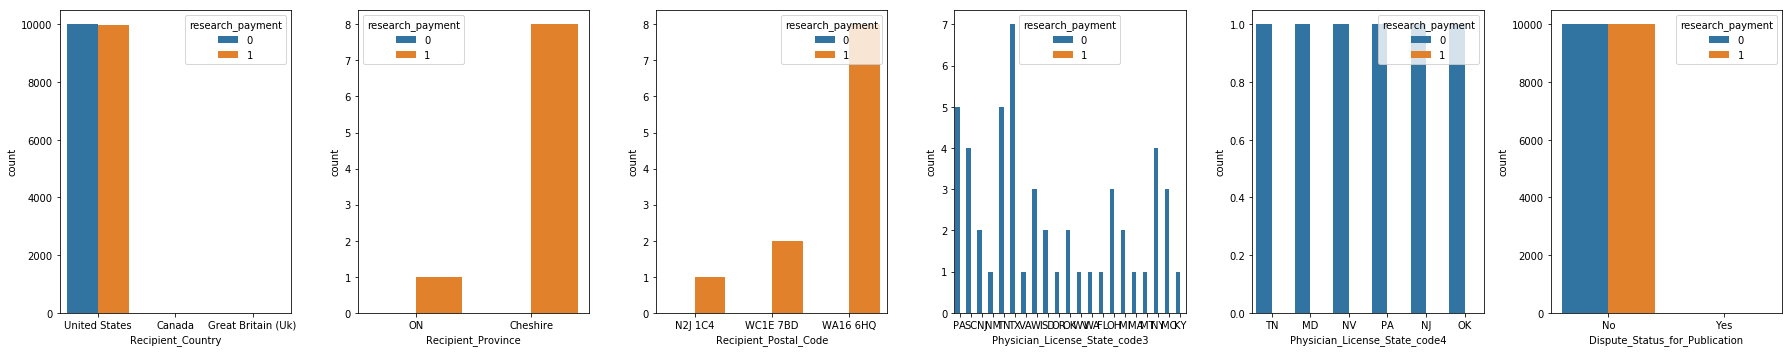

In [9]:
cols_drop = []
for v in df.columns.values[:-1]:
    for i in range(2):
        if len(df[df['research_payment'] == i][v].unique()) == 1:
            if v not in cols_drop: cols_drop.append(v)

                
fig, ax = plt.subplots(1, len(cols_drop), figsize = (25, 5))
i=0
for v in cols_drop:
    sns.countplot(v, hue='research_payment', data = df, ax = ax[i])
    i+=1
    
plt.tight_layout()

In [13]:
cols_drop.remove('Recipient_Country')
cols_drop.remove('Dispute_Status_for_Publication')
df.drop(cols_drop, axis=1, inplace=True)

A big portion of our features don't have any data for one of the targets. 

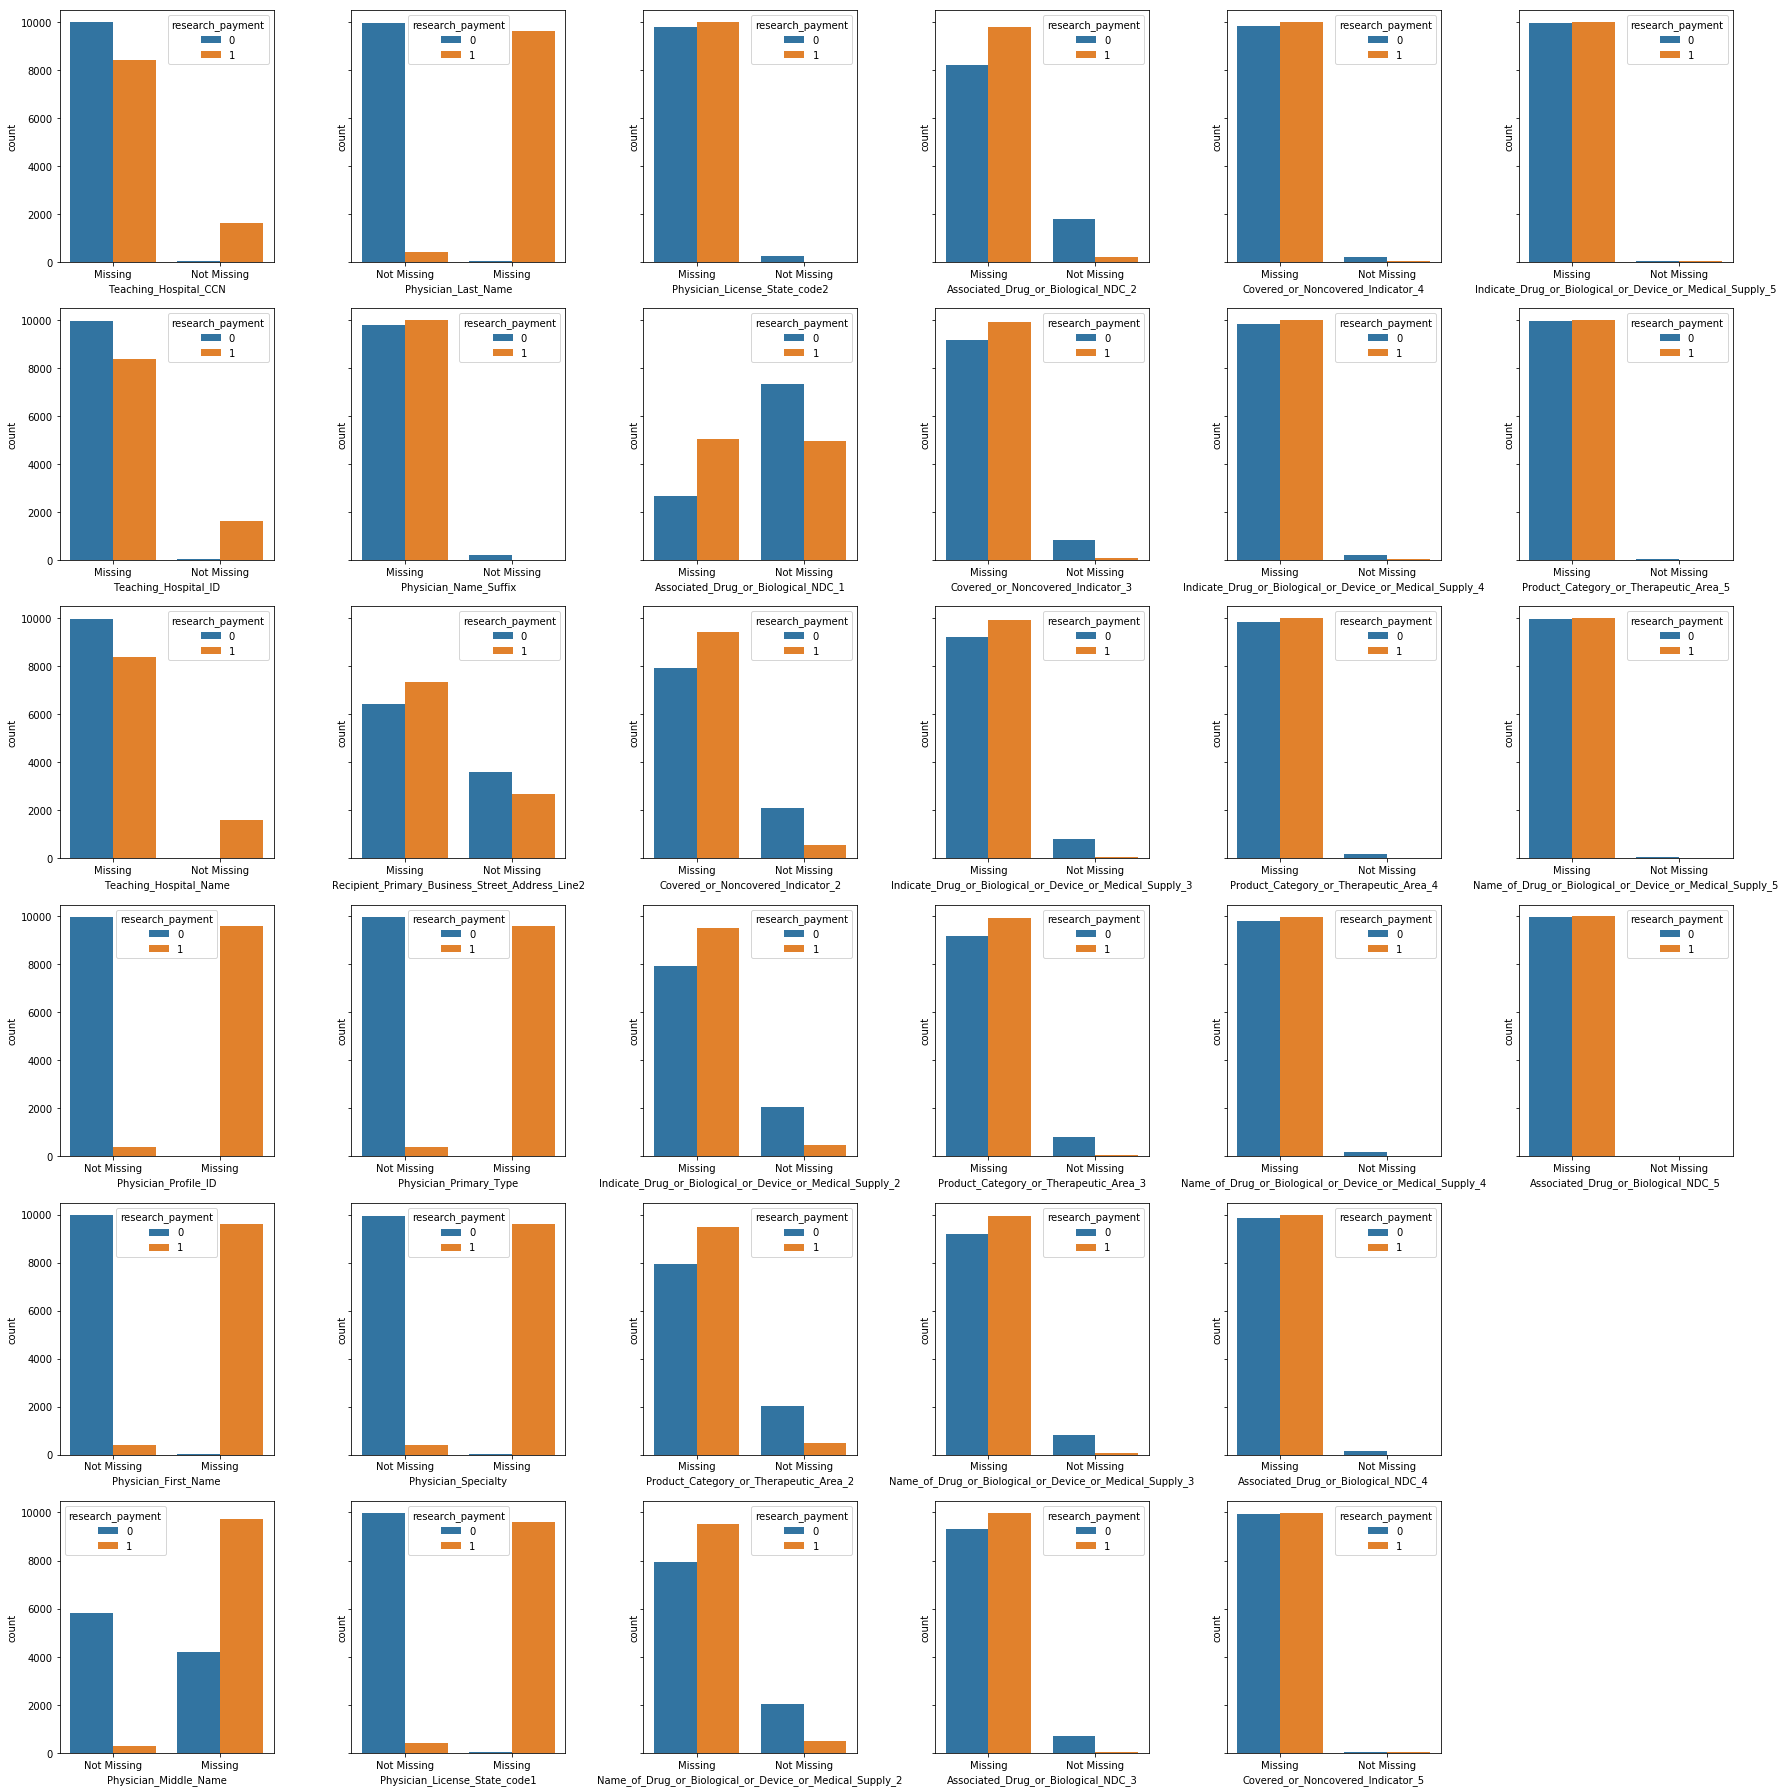

In [15]:
df_missing = df.copy()
for c in df_missing.columns[:-1]:
    df_missing[c] = np.where(df_missing[c].isnull(), 'Missing', 'Not Missing')

fig, ax = plt.subplots(6, 6, figsize = (25, 25), sharey='row')
# axis indicators
i = 0
j = 0

for v in df_missing.columns.values[:-1]:
    if df_missing[df_missing[v] == 'Missing'].shape[0] > (df_missing.shape[0] / 4):
        sns.countplot(v, hue='research_payment', data = df_missing, ax=ax[i,j])

        # increment axis
        i += 1
        if i == 6: j += 1; i = 0
        
        
fig.delaxes(ax[5,5])
fig.delaxes(ax[4,5])
plt.tight_layout()
plt.show()

# How do you think we should decide which to remove and which to keep? 

Finally, we split between X and y, which gives us our dataset. 

In [178]:
X = df.drop('research_payment', axis=1)
y = df['research_payment']